# Введение

Структура скрипта:

1. Импорт библиотек и настройка среды выполнения.
2. Загрузка исторических данных о котировках активов.
3. Сравнение кумулятивной доходности активов.
4. Оптимизация портфеля акций методом Монте-Карло.

# Импорт библиотек и настройка среды выполнения

In [1]:
import pandas as pd # для создания датафреймов
import numpy as np # для математических преобразований
import datetime as dt # для работы с датами
import matplotlib.pyplot as plt # для посроения графиков
from matplotlib import style # для настройки стиля графиков
import pandas_datareader.data as web # для загрузки данных из веба
from dateutil.relativedelta import relativedelta # для математических вычислений с датами

In [2]:
style.use('ggplot') # установка стиля графиков

start = dt.datetime(2019, 1, 1) # самая ранняя дата периода, за который будем загружать информацию
today = dt.datetime.now() # самая поздняя дата периода, за который будем загружать информацию, т.е. сегодня

# Загрузка исторических данных о котировках ценных бумаг

В рамках данного исследования будут рассматриваться котировки акций нескольких компаний:
* Microsoft (тикер MSFT)
* Apple (тикер AAPL)
* Visa (тикер V)
* Intel (тикер INTC)
* Activision Blizzard (тикер ATVI)
* М.Видео (тикер MVID)
* Сбербанк - привилегированные (тикер SBERP) 

Данные компании были отобраны по следующим прицницам: 
* Представляют технологическую и финансовые отрасли, имеющие хорошую динамику развития.
* Демонстрируют стремление к постоянному развитию своих продуктов.
* Не демонстрируют снижение выручки в последние несколько лет.
* Не показывали убыток за последние несколько лет.
* Стабильно выплачивают дивидены.
* Мультипликатор P/E менее 50.

In [3]:
# Определим список тикеров. Нам также нужно загрузить курсы доллара к рублю для конвертации рублевых тикеров в доллары. Тикеры, торгуемые на Московской бирже, имеют окончание .ME
tickers = ['USDRUB=X', 'MSFT', 'AAPL', 'V', 'INTC', 'ATVI', 'MVID.ME', 'SBERP.ME']

# Создадим пустой датафрейм, в котором каждый столбец соответсвует каждому тикеру из списка.
stock_data = pd.DataFrame(columns=tickers)

Для загрузки данных будем использовать библиотеку pandas_datareader. Она может использовать различные источники данных, но в данном скрипте будет использоватья Yahoo Finance. Компании, торгуемые на Московской бирже, имеют окончание .ME. Период, за который будут загружаться данные о котировках: с 1 января 2019 года по текущий день. Для анализа будет использоваться скорректированная цена закрытия на конец дня (цена закрытия, скорректированная на дивиденды и сплиты). Точность временных данных в один день недостаточна для алгоритмической торговли, но достаточна для целей данного исследования: фундаментальной балансировки портфеля.

In [4]:
for ticker in tickers:
    stock_data[ticker] = web.DataReader(ticker, 'yahoo', start, today)['Adj Close']

Для тикеров, номинированных в рублях, необходимо сконвертировать стоимость из рублей в доллары. После этого информацию о курсе доллара к рублю можно отбросить.

In [5]:
moex_tickers = [ticker for ticker in tickers if '.ME' in ticker]

# Курс российских акций в долларах = курс акций в рублях / курс доллара к рублю.
for moex_ticker in moex_tickers:
    stock_data[moex_ticker] = stock_data.apply(lambda row: row[moex_ticker] / row['USDRUB=X'], axis=1)

stock_data.drop(columns='USDRUB=X', inplace=True) # удалим курс доллара к рублю
stock_data.columns = stock_data.columns.str.rstrip('.ME') # удалим окончание .ME для российских тикеров 

# Сравнение кумулятивной доходности активов

Нас интересует не сравнение курсов акций в абсолютном выражении и не изучение истории колебаний курсов, а относительный возврат на инвестиции - выраженный как нарастающий итог изменения доходности. Отобразим итог по кумулятивной доходности акций, актуальный по состоянию на сегодня, в графическом и матричном виде. Информацию будем анализировать за годовой период и трехмесячный период.

In [6]:
def cumulative_return(period):
# Определение функции для вычисления кумулятивного возврата на инвестиции. Функция принимает один аргумент: строкое обозначение временного периода, за который нужно проанализировать возврат на инвестиции.

    # дата отсчета вычисляется в зависимости от переданного функции аргумента 
    if period == "год":
        time_interval = today - relativedelta(years=1)
    elif period == "квартал":
        time_interval = today - relativedelta(months=3)
    else: 
        print("Указан недопустимый период")
        return

    # ограничим набор данных в соответствии с заданным периодом
    last_period_stock_data = stock_data[stock_data.index >= time_interval]
    cumulative_return = (last_period_stock_data.pct_change() + 1).cumprod() - 1
    
    # отображение возврата на инвестиции в виде графика
    cumulative_return.plot()
    plt.title(f"Кумулятивная доходность за последний {period}")
    plt.legend()
    plt.ylabel('Доходность')
    plt.xlabel('Период')
    plt.show()

    # отображение возврата на инвестиции в виде матрицы
    cumulative_total_return = cumulative_return.tail(1).transpose()
    cumulative_total_return.sort_values(by=cumulative_total_return.columns[0], ascending=False, inplace=True)
    cumulative_total_return = cumulative_total_return.apply(lambda row:"{:.2%}".format(row[0]),  axis=1)
    print(f'Кумулятивная доходность за последний {period}:\n{cumulative_total_return.to_string()}')

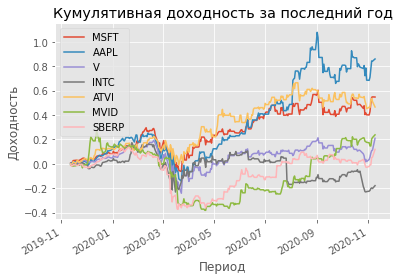

Кумулятивная доходность за последний год:
AAPL      85.94%
MSFT      54.74%
ATVI      46.56%
MVID      23.74%
V         20.91%
SBERP     11.82%
INTC     -17.92%


In [7]:
cumulative_return('год')

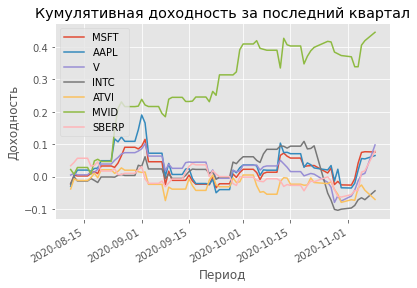

Кумулятивная доходность за последний квартал:
MVID     44.55%
V         9.79%
SBERP     7.90%
MSFT      7.61%
AAPL      6.51%
INTC     -4.37%
ATVI     -7.04%


In [8]:
cumulative_return('квартал')

# Оптимизация портфеля методом Монте-Карло 

В рамках данного исследования оптимальным портфелем будем считать портфель с максимальным коэффициентом Шарпа. Коэффициент Шарпа можно использовать для определения того, насколько хорошо доходность портфеля компенсирует возможные риски по данному портфелю. При прочих равных условиях портфель с более высоким коэффициентом Шарпа будет считаться более сбалансированным. Добиться максимизации коэффициента Шарпа можно подбором оптимальных весов для каждой ценной бумаги в портфеле. 

Коэффициент Шарпа вычисляется по следующей формуле:
$$ Sharpe = \frac{(R_{p}–R_{f})}{\sigma_{p}} , $$
где:

$R_{p}$ - ожидаемая доходность портфеля,

$R_{f}$ - доходность безрискового актива (risk-free rate),

$\sigma_{p}$ - стандартное отклонение доходности портфеля.

Ожидамая доходность портфеля вычисляется по следующей формуле:
$$ R_{p} = (w_{1} * r_{1}) + (w_{2} * r_{2}) + ... + (w_{n} * r_{n}) ,$$
где:

$r_{i}$ - доходность актива из портфеля,

$w_{i}$ - вес актива в портфеле.

Стандартное отклонение доходности портфеля вычисляется как:
$$ \sigma_{p} = \sqrt{(w_{i}^2 * \sigma_{i}^2) + (w_{j}^2 * \sigma_{j}^2) + (2 * w_{j} * w_{i} * p_{i,j} * \sigma_{i} * \sigma_{j})} ,$$
где:

$p_{i,j}$ - коэффициент корреляции между доходностью активов в портфеле.  



В качестве ставки доходности безрискового актива примем ставку по годовым долларовым депозитам в Банке Авангард (её можно считать средней по рынку), которая на момент написания скрипта составляла 0,4% годовых.

Для поиска портфеля с оптимальными параметрами будем проводить симуляцию портфелей методом Монте-Карло, создав 10000 портфелей со случайным образом подобранными весами активов. Для каждого портфеля будет вычисляться ожидаемая доходность и волатильность (стандартное отклонение).

In [9]:
# Зададим параметры испытаний Монте-Карло.
number_of_tickers = len(stock_data.columns)
risk_free_rate = 0.004 
number_of_portfolios = 10000

# Для математического прогнозирования доходности необходимо проводить усреднение доходности. Для корректного вычисления усредненной во времени доходности необходимо работать с логарифмом доходности.
log_returns = np.log(stock_data/stock_data.shift(1))

# Создадим массивы, заполненные нулями, для хранения значений весов, доходностей и волатильности активов, а также коэффициентов Шарпа.
weights_array = np.zeros((number_of_portfolios, number_of_tickers))
returns_array = np.zeros(number_of_portfolios)
volatilities_array = np.zeros(number_of_portfolios)
sharpe_ratios_array = np.zeros(number_of_portfolios)

# Проведение симуляции.
for portfolio in range(number_of_portfolios):

    # Генерируются случайные веса. Сумма весов не должна превышать 1. Далее веса добавляются в массив весов.
    weights = np.array(np.random.random(number_of_tickers))
    weights = weights / np.sum(weights)
    weights_array[portfolio, :] = weights

    # Вычисление ожидаемой доходности. Ожидаемую логарифмированную доходность необходимо аннуализировать, т.е. привести к среднегодовому значению с учетом количества торговых дней в году (252).
    returns_array[portfolio] = np.sum((log_returns.mean() * weights) * 252)

    # Вычисление волатильности.
    volatilities_array[portfolio] = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

    # Вычисление коэффициентов Шарпа.
    sharpe_ratios_array[portfolio] = (returns_array[portfolio] - risk_free_rate) / volatilities_array[portfolio]

# Сведение массивов в единый массив.
simulations_data = [returns_array, volatilities_array, sharpe_ratios_array, weights_array]

# Создание датафрейма из единого массива и приведение его в привычный вид.
simulations_df = pd.DataFrame(data=simulations_data).T
simulations_df.columns = [
    'Доходность',
    'Волатильность',
    'Коэффициент Шарпа',
    'Веса активов'
]

simulations_df = simulations_df.infer_objects() # для корректного определения типа данных

# Выведем веса активов в отдельные столбцы.
simulations_df[list(stock_data.columns)] = pd.DataFrame(simulations_df['Веса активов'].to_list(), columns=[list(stock_data.columns)])
simulations_df.drop(columns='Веса активов', inplace = True)

In [10]:
# Найдем портфель с максимальным коэффициентом Шарпа.
max_sharpe_ratio = simulations_df.iloc[simulations_df['Коэффициент Шарпа'].argmax()]
print(f"Результат портфеля c наибольшим коэффициентом Шарпа:\n{max_sharpe_ratio[['Доходность', 'Волатильность', 'Коэффициент Шарпа']].to_string()}")
print(f"\nСтруктура портфеля:\n{max_sharpe_ratio.drop(labels=['Доходность', 'Волатильность', 'Коэффициент Шарпа']).to_string()}")

Результат портфеля c наибольшим коэффициентом Шарпа:
Доходность           0.417663
Волатильность        0.242738
Коэффициент Шарпа    1.704151

Структура портфеля:
MSFT     0.328670
AAPL     0.158148
V        0.022115
INTC     0.003254
ATVI     0.021060
MVID     0.290943
SBERP    0.175808


In [11]:
# Найдем портфель с наибольшей доходностью.
max_returns = simulations_df.iloc[simulations_df['Доходность'].argmax()]
print(f"Результат портфеля c наибольшей доходностью:\n{max_returns[['Доходность', 'Волатильность', 'Коэффициент Шарпа']].to_string()}")
print(f"\nСтруктура портфеля:\n{max_returns.drop(labels=['Доходность', 'Волатильность', 'Коэффициент Шарпа']).to_string()}")

Результат портфеля c наибольшей доходностью:
Доходность           0.439981
Волатильность        0.283229
Коэффициент Шарпа    1.539325

Структура портфеля:
MSFT     0.379148
AAPL     0.322599
V        0.016815
INTC     0.005623
ATVI     0.008015
MVID     0.158257
SBERP    0.109543


In [12]:
# Найдем портфель с наименьшей волатильностью.
min_volatility = simulations_df.iloc[simulations_df['Волатильность'].argmin()]
print(f"Результат портфеля c наименьшей волатильностью:\n{min_volatility[['Доходность', 'Волатильность', 'Коэффициент Шарпа']].to_string()}")
print(f"\nСтруктура портфеля:\n{min_volatility.drop(labels=['Доходность', 'Волатильность', 'Коэффициент Шарпа']).to_string()}")

Результат портфеля c наименьшей волатильностью:
Доходность           0.372789
Волатильность        0.224086
Коэффициент Шарпа    1.645745

Структура портфеля:
MSFT     0.134368
AAPL     0.008788
V        0.015339
INTC     0.028278
ATVI     0.224432
MVID     0.290878
SBERP    0.297917


Теперь построим диаграмму рассеяния, отражающую взаимосвязь между ожидаемой доходностью, волотильностью и коэффициентом Шарпа.

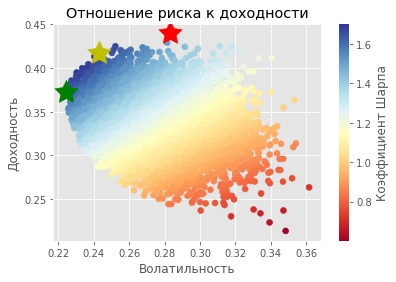

In [13]:
plt.scatter(
    y=simulations_df['Доходность'],
    x=simulations_df['Волатильность'],
    c=simulations_df['Коэффициент Шарпа'],
    cmap='RdYlBu'
)

plt.title('Отношение риска к доходности')
plt.colorbar(label='Коэффициент Шарпа')
plt.xlabel('Волатильность')
plt.ylabel('Доходность')

# Максимальному коэффициенту Шарпа будет соответствовать желтая звезда.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='y',
    s=600
)

# Миминимальной волатильности будет соответствовать зеленая звезда.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='g',
    s=600
)

# Максимальной доходности будет соответствовать красная звезда.
plt.scatter(
    max_returns[1],
    max_returns[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

plt.show()